In [40]:
from copy import deepcopy
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple
from sklearn.model_selection import train_test_split

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext import vocab
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer

import math

from tqdm.auto import tqdm

dataset = load_dataset("imdb")


Found cached dataset imdb (C:/Users/leand/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

# GloVe

In [41]:
torch.manual_seed(0)

In [42]:
glove = GloVe(name="6B", dim=300)
len(glove.stoi)

400000

In [43]:
glove.stoi["cat"], glove.itos[5450], glove.vectors[glove.stoi["cat"]].shape

(5450, 'cat', torch.Size([300]))

In [44]:
glove.itos[:5]

['the', ',', '.', 'of', 'to']

In [45]:
words = ["cat", "cats", "dog", "fridge"]
for word in words[1:]:
    similarity = torch.cosine_similarity(
        glove.vectors[glove.stoi[words[0]]].reshape(1, -1),
        glove.vectors[glove.stoi[word]].reshape(1, -1),
    ).item()  # .item() is used to turn a tensor of a single value to a float
    print(f"{words[0]} x {word} = {similarity}")

cat x cats = 0.6815836429595947
cat x dog = 0.6816746592521667
cat x fridge = 0.09630905091762543


In [46]:
def closest_word(word : str) -> None:
    max_similarity = 0
    max_string_similarity = word
    for words in glove.itos:
        similarity =  torch.cosine_similarity(
            glove.vectors[glove.stoi[words]].reshape(1, -1),
            glove.vectors[glove.stoi[word]].reshape(1, -1),
        ).item()  # .item() is used to turn a tensor of a single value to a float
        if (similarity > max_similarity and word != words):
                max_similarity = similarity
                max_string_similarity = words
                #print(f"{max_string_similarity} x {word_cat} = {max_similarity}")
    print(f"{max_string_similarity} x {word} = {max_similarity}")

In [47]:
word = "cat"

closest_word(word)

dog x cat = 0.6816746592521667


In [48]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (C:/Users/leand/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\leand\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-5f37fd0866e4f89f.arrow and C:\Users\leand\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

In [49]:
tokenizer = get_tokenizer("basic_english", language="en")

def vectorize_text(
    text: str, vocabulary: vocab.Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Turn a string into the average of the vectors of its tokens.
    Args:
        text: the input text.
        vocabulary: a pre-trained Vocab object.
        tokenizer: a tokenizer taking a text as input and returning a list of tokens.
    Returns:
        The average tensor over the tokens of the whole text.
    """
    tokens = tokenizer(text)
    vectors = vocabulary.get_vecs_by_tokens(tokens)
    return torch.mean(vectors, dim=0)

In [50]:
text_pipeline = partial(vectorize_text, vocabulary=glove, tokenizer=tokenizer)
assert text_pipeline("some text.").shape == torch.Size([300])

In [51]:
text_pipeline("some text.").shape

torch.Size([300])

In [52]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [53]:
def data_generator(
    X: List[torch.tensor], y: List[int], batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    num_batches = (len(X) - 1) // batch_size + 1

    for i in range(num_batches) :
        starting_index = i * batch_size
        ending_index = min((i + 1) * batch_size, len(X))
        batch_X = X[starting_index:ending_index]
        batch_Y = y[starting_index:ending_index]
        yield torch.stack(batch_X), torch.tensor(batch_Y)


In [54]:
train_gen = lambda: data_generator(X_train, y_train, batch_size=32)
for X, y in train_gen():
    assert X.shape == torch.Size([32, 300])
    assert y.shape == torch.Size([32])
    break

In [55]:
class SimpleClassifer(nn.Module):
    """
    A simple linear classifier.
    """

    def __init__(self, embedding_size: int, nb_classes: int) -> None:
        """
        Args:
            embedding_size: the dimension of the input embeddings.
        nb_classes: the output dimension.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(embedding_size, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: an input tensor
        Returns:
            Logits.
        """
        return self.classifier(x)
        

In [56]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [57]:
train_gen = lambda: data_generator(X_train, y_train)
valid_gen = lambda: data_generator(X_valid, y_valid)
test_gen = lambda: data_generator(X_test, y_test)

In [58]:
model = SimpleClassifer(300, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
# You can use another optimizer if you want.
optimizer = torch.optim.Adam(model.parameters())

In [59]:
nb_epochs = 50
train_losses, valid_losses = [], []

best_model = model
best_validation_loss = np.Inf

for epoch in tqdm(range(nb_epochs)):

    # training
    model.train()
    train_loss = 0.0
    # training loop
    for batch_X, batch_Y in train_gen():
        optimizer.zero_grad()
        logits = model(batch_X.to(device)).squeeze()
        loss = criterion(logits, batch_Y.float())#to device
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
      
    train_losses.append(train_loss / len(X_train))


    
    # validation
    model.eval()
    valid_loss = 0.0
    # validation loop
    with torch.no_grad():
        for batch_X, batch_Y in valid_gen():
            logits = model(batch_X.to(device)).squeeze()
            loss = criterion(logits, batch_Y.float())
            valid_loss += loss.item()
    valid_losses.append(valid_loss / len(X_valid))

    if (valid_losses[-1] < best_validation_loss) :
        best_validation_loss = valid_losses[-1]
        best_model = deepcopy(model)

print(best_validation_loss)
print(train_losses)
print(valid_losses)

  0%|          | 0/50 [00:00<?, ?it/s]

0.018939454710483552
[0.021631055256724357, 0.021205577996373178, 0.020859843373298645, 0.02062277730703354, 0.02044290569126606, 0.02029460217654705, 0.020160146716237066, 0.02004516155719757, 0.01993906832933426, 0.01984562477171421, 0.01975999783873558, 0.01968287192285061, 0.01961188557446003, 0.019549551439285277, 0.019493003463745117, 0.019442262056469917, 0.019397375747561455, 0.01935203246176243, 0.019311928334832192, 0.01927521131336689, 0.019240899878740312, 0.019208967417478563, 0.01917510914802551, 0.01914895717203617, 0.019120442527532578, 0.019097436946630478, 0.019074421909451484, 0.019049943995475768, 0.019029462738335133, 0.019009073215723038, 0.018988674852252006, 0.0189690727353096, 0.018951398192346095, 0.01893559999167919, 0.018919165381789206, 0.018903254440426825, 0.01888887039422989, 0.018872761246562005, 0.0188601156309247, 0.018845784604549408, 0.018833718673884867, 0.018821373867988586, 0.018809604074060918, 0.018798735776543618, 0.018787166699767113, 0.01877

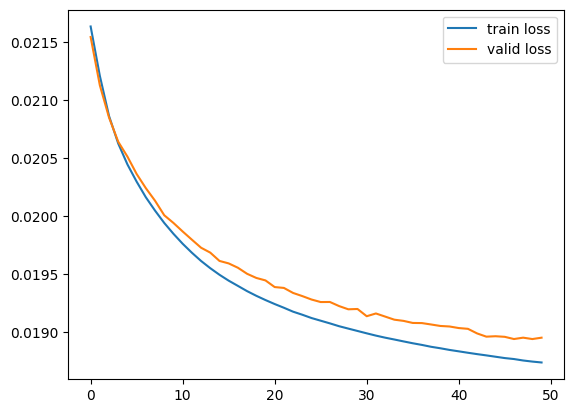

In [60]:
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()

In [61]:
def accuracy_computing(generator,X):
    best_model.eval()
    accuracy = 0
    with torch.no_grad():
        for batch_X, batch_Y in generator():
            logits = best_model(batch_X).squeeze()
            predictions = (logits > 0.5)
            accuracy += (predictions.int() == batch_Y).int().sum().item()
    accuracy /= len(X)
    return accuracy
        

train_accuracy = accuracy_computing(train_gen, X_train)
valid_accuracy = accuracy_computing(valid_gen, X_valid)
test_accuracy = accuracy_computing(test_gen, X_test)

print(train_accuracy, valid_accuracy, test_accuracy)

0.80445 0.8016 0.79624


In [62]:
def predict(
    text: str,
    text_pipeline: Callable[[str], torch.Tensor],
    model: nn.Module,
    device: str,
) -> Tuple[int, float]:
    """
    Return the predicted class and score for a given input.
    Args:
        text: a given review.
        text_pipeline: a function taking a text as input and returning a tensor (model's input).
        model: a pre-trained model.
        device: the device on which the computation occurs.
    Returns:
        A tuple (label, score).
    """
    score = model.forward(text_pipeline(text)).to(device)[0].item()
    return int(score > 0.5), score

In [63]:
def error_searching(X_train: list[str], y_train: list[int]) -> None:
    best_model.eval()
    found = 0
    i = 0
    while i < len(X_train) and found < 2:
        result, score = predict(X_train[i], text_pipeline, best_model, device)
        if result != y_train[i]:
            print(X_train[i])
            print("Résultat obtenu :", result)
            print("Résultat escompté :", y_train[i])
            print("Score obtenu :", score)
            if found == 0:
                print("\n\n\n\n\n")
            found += 1
        i += 1

error_searching(train_df["text"], train_df["label"])

After reading tons of good reviews about this movie I decided to take it for a spin (I bought it on DVD, hence the "spin" pun...I'm a dork). The beginning was everything I hoped for, a perfect set-up (along with some quotes that I've heard on Various Wu-Tang albums) to what should have been a good movie. But the plot I heard was so great, was so predictable. Every time I saw a character (except for the Lizard) I guessed which Venom he was. Plus, the only cool character gets killed off in the middle of the movie. Ok, so the plot wasn't very good but at least there was some good kung-fu right? Wrong. The fights were very short and few and far between. Granted the different styles were all pretty cool but I wish the fights were longer. I kept hoping to see the Lizard run and do some crazy ish on the walls but it never happened. I was hoping to see the Centipede do some tight speedy ish but it never happened. I was hoping to see the Scorpion in the movie for more than 7 total minutes but i

In [64]:
type(train_df["label"][0])

int

Le premier texte correspond à un avis d'une personne très déçue du film qu'elle a vu. Elle a donc globalement apprécié, mais beaucoup moins que ce qu'elle n'aurait voulu : son texte étant majoritairement négatif, notre classifieur l'a donc noté comme étant extrêmement négatif avec un score de 0.02.

Le second texte, quant à lui, indique que le film était intéressant, mais beaucoup trop complexe et difficile à suivre pour être appréciable en tant que visionnage tranquille : malgré tous les points positif qu'il cite, l'auteur indique clairement qu'il n'a presque rien compris à l'histoire. D'où son avis négatif, et notre estimation positive.


In [65]:
text = "In my long years as a movie reviewers, I have seen good and bad movies. But nothing as controversially in the middle."
predict(text, text_pipeline, model, device)

(0, 0.21899402141571045)

# II- FastText

In [66]:
import fasttext as ft

ModuleNotFoundError: No module named 'fasttext'

1- Turn the dataset into a dataset compatible with Fastext

In [ ]:
import string

def preprocess(data : dict) -> dict:
    '''Takes a document from a dataset, lowers the letters and
    replace all punctuations by spaces'''
    text = data["text"]
    for character in string.punctuation:
        if character != "-":
          text = text.replace(character, ' ')
    data["text"] = text.lower()
    return data

In [ ]:
updated_dataset = dataset.map(preprocess)


In [ ]:
def to_ft_dataset(dataset, file):
    with open(file, 'w') as f:
        for d in dataset:
            label = '__label__' + str(d['label'])
            text = d['text']
            f.write(label + ' ' + text + '\n')
    return file

2- Train a FastText classifier with default parameters

In [ ]:
train_ft_file = to_ft_dataset(updated_dataset["train"], "ft_train_dataset.txt")
test_ft_file = to_ft_dataset(updated_dataset["test"], "ft_test_dataset.txt")

In [ ]:
import random

with open("ft_train_dataset.txt", 'r') as f:
    train_lines = f.readlines()

# Shuffle the training data
shuffle(train_lines)
with open("ft_train_dataset.txt", 'w') as f:
    f.writelines(train_lines)

In [ ]:
model = ft.train_supervised(input="ft_train_dataset.txt")

In [ ]:
_, p, _ = model.test(test_ft_file)
print("L'accuracy est de:", p, "%")

3- Use the hyperparameters search functionality of FastText

In [ ]:

with open("ft_train_dataset.txt", 'r') as f:
    data = []
    labels = []
    for line in f:
        label, text = line.split(maxsplit=1)
        data.append(text)
        labels.append(label)

X_train, X_valid, Y_train, Y_valid = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Combine the data and labels into the format expected by FastText
train = [f"{label} {text.strip()}\n" for label, text in zip(Y_train, X_train)]
val = [f"{label} {text.strip()}\n" for label, text in zip(Y_valid, X_valid)]

# Save the training and validation data to separate files
with open('ft_train_dataset.txt', 'w') as f:
    f.writelines(train)
with open('ft_valid_dataset.txt', 'w') as f:
    f.writelines(val)


In [ ]:
model_hyperparameters = ft.train_supervised(input='ft_train_dataset.txt', autotuneValidationFile='ft_valid_dataset.txt', autotuneDuration=300)

In [ ]:
_, p, _ = model.test("ft_valid_dataset.txt")
print("L'accuracy est de:", p, "%")